In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Off-policy Monte-Carlo Control

In [2]:
def getGreedyPolicy(Q):
    return np.argmax(Q,axis=-1)

def OffPolicyMCControl(episode, Q, C, target_policy, getBehaviourDist, gamma):
    b_policy = getBehaviourDist()
    G = 0.0
    W = 1.0
    converged = True
    step = len(episode)-1
    for state, action, reward in reversed(episode):
        G = gamma*G + reward
        C[state][action] += W
        q = Q[state][action]
        Q[state][action] += W/C[state][action] * (G-Q[state][action])
        converged = converged and abs(q - Q[state][action]) < CONVERGENCE_ERROR
        target_policy[state] = np.argmax(Q[state])
        if target_policy[state] != action: break
        W *= 1.0/b_policy[state][action]
        step -= 1
    
    #print("\repisode length:{:7}; steps used:{:3}".format(len(episode),len(episode)-step), 
    #      end='', flush=True)
    return converged

### On-policy Monte-Carlo Control

In [3]:
def OnPolicyFirstVisitMCControl(episode, Q, C, gamma):
    visited = set()
    x_episode = []
    for state, action, reward in episode:
        is_first = not (state,action) in visited
        if is_first:
            visited.add((state,action))
        x_episode.append((state, action, reward, is_first))
    
    converged = False
    G = 0
    for state, action, reward, is_first in reversed(x_episode):
        G = gamma*G + reward
        if not is_first: 
            continue
        
        C[state][action] += 1
#        q = Q[state][action]
        Q[state][action] += (G-Q[state][action])/C[state][action]
#        converged = converged and abs(q - Q[state][action]) < CONVERGENCE_ERROR
#        greedy_policy[state] = np.argmax(Q[state])
    
    #print("\repisode length:{:7}; steps used:{:3}".format(len(episode),len(episode)-step), 
    #      end='', flush=True)
    return converged

def OnPolicyEveryVisitMCControl(episode, Q, C, gamma):
    converged = False
    G = 0
    for state, action, reward in reversed(episode):
        G = gamma*G + reward
        C[state][action] += 1
        Q[state][action] += (G-Q[state][action])/C[state][action]
    
    return converged

### Procedure to run learning

In [4]:
def learnByEpisode(sequence, learnMethod):
    conv_count = 0
    episode = []

    for st,is_term,st_nx,ac,rw in sequence:
        episode.append((st,ac,rw))
        if not is_term:
            continue
        if len(episode) == 0: break
        print(" Episode #: {:7}; length: {:7}\r".format(sequence.episode_i-1, len(episode)), 
              end='', flush=True)

        if learnMethod(episode, sequence.episode_i-1):
            conv_count += 1
        else: 
            conv_count = 0
        if conv_count >= 500:
            print("\nConvergence reached.")
            break
            
        episode = []
        
    print("\nEpisodes generated: {}".format(sequence.episode_i-1))

#### Some geometry

In [5]:
def getRelative(base, line):
    return line-base
    
def det(v1,v2):
    return v1[0]*v2[1]-v1[1]*v2[0]

def is_intersection(l1, l2):
    return (det(*getRelative(l1[0],l2)) < 0) != (det(*getRelative(l1[1],l2)) < 0) \
           and (det(*getRelative(l2[0],l1)) < 0) != (det(*getRelative(l2[1],l1)) < 0)

### Implementation of RaceTrack environment

In [6]:
MAX_VELOCITY = 4
MIN_VELOCITY = 0

rt_contour_1 = [
    [3,0],[3,3],[2,3],[2,10],[1,10],[1,18],[0,18],[0,28],[1,28],[1,29],[2,29],
    [2,31],[3,31],[3,32],[17,32],[17,26],[10,26],[10,25],[9,25],[9,0],[3,0]
]
start_line_1 = (3,0,9,1)
finish_line_1 = (16,26,17,32)
track_shape_1 = (17,32)
ACCELERATION =  [[1,-1],  [1,0],  [1,1],
                 [0,-1],  [0,0],  [0,1],
                [-1,-1], [-1,0], [-1,1]]
ACTIONS_NUM = len(ACCELERATION)

REWARD = -1
CONVERGENCE_ERROR = 0.02


In [7]:
def rt_getStartPosition(start_line):
    return (np.random.randint(start_line[0], start_line[2]),0,0,0)

def is_finished(finish_line, position, next_position):
    return is_intersection(np.array([(finish_line[0],finish_line[1]),
                                     (finish_line[0],finish_line[3])]),
                           np.array([np.array(position)+0.5, 
                                     np.array(next_position)+0.5]))

def is_runout(contour, position, next_position):
    it = iter(contour)
    p1 = next(it)
    for p2 in it:
        if is_intersection(np.array([p1,p2]), 
                           np.array([np.array(position)+0.5, 
                                     np.array(next_position)+0.5])):
            return True
        p1 = p2
    return False

def rt_getTransition(track_contour, state, action, finish_line, 
                     getStartPosition=lambda: rt_getStartPosition(start_line_1)):
    accel = ACCELERATION[action]
    next_velocity = np.clip([state[2]+accel[0],state[3]+accel[1]], 
                            MIN_VELOCITY, MAX_VELOCITY)
    if (next_velocity == 0).all():
        next_velocity = np.array([state[2],state[3]])
    position = np.array([state[0],state[1]])
    next_position = position + next_velocity
    next_state = tuple(next_position) + tuple(next_velocity)

    if is_finished(finish_line, position, next_position):
        return (True,next_state)

    if is_runout(track_contour, position, next_position):
        next_state = getStartPosition()

    return (False,next_state)


#### Test of RaceTrack environment

In [101]:
rt_getTransition(rt_contour_1, (3,0,0,0), 3, finish_line_1, 
                 getStartPosition=lambda: rt_getStartPosition(start_line_1))

(False, (3, 0, 0, 0))

### Setup the environment 

In [8]:
import sys
sys.path.append('..')
import SeqGen
QShape = track_shape_1 + (MAX_VELOCITY+1, MAX_VELOCITY+1, ACTIONS_NUM)

In [9]:
np.random.seed(113)
Q = (np.random.random(QShape)-0.5)*0.001 - 300.0

In [106]:
sequence = SeqGen.SequenceGeneratorPlus(
                SeqGen.EpsilonGreedyPolicy(Q, 0.1),
                lambda: rt_getStartPosition(start_line_1),
                lambda s,a: rt_getTransition(
                        rt_contour_1, s, a, finish_line_1, 
                        getStartPosition=lambda: rt_getStartPosition(start_line_1))
                    + (REWARD,),
                episodes_max=1000
               )

#### Obsoleted. Left for testing purposes.

In [105]:
def MC_run(sequence, Q, C, gamma):
    conv_count = 0
    it = iter(sequence)
    while True:
        episode = []
        try: 
            while True:
                st,is_term,st_nx,ac,rw = next(it)
                episode.append((st,ac,rw))
                if is_term: break
        except StopIteration:
            print("\nSequence terminated.")
            break
        if len(episode) == 0: break
        print(" Episode #: {:7}; length: {:7}\r".format(sequence.episode_i-1, len(episode)), 
              end='', flush=True)

        t_policy = getGreedyPolicy(Q)
    
        if OffPolicyMCControl(episode, Q, C, t_policy, sequence.get_action.getDistribution, gamma):
            conv_count += 1
        else: 
            conv_count = 0
        if conv_count >= 500:
            print("\nConvergence reached.")
            break
        
    print("\nEpisodes generated: {}".format(sequence.episode_i-1))

In [107]:
C = np.zeros(dtype=np.float, shape=Q.shape)
MC_run(sequence, Q, C, 0.99)

 Episode #:    1000; length:      19
Sequence terminated.

Episodes generated: 1000


### Run Off-policy MC Control learning

In [ ]:
C = np.zeros(dtype=np.float, shape=Q.shape)

In [38]:
t_policy = getGreedyPolicy(Q)
learnByEpisode(sequence, 
               lambda e,i: OffPolicyMCControl(e, Q, C, t_policy, 
                                sequence.get_action.getDistribution, 0.99))

 Episode #:    1000; length:     111
Episodes generated: 1000


### Run On-policy First Visit MC Control learning

In [33]:
np.random.seed(113)
Q = (np.random.random(QShape)-0.5)*0.001 - 300

In [34]:
sequence = SeqGen.SequenceGeneratorPlus(
                SeqGen.EpsilonGreedyPolicy(Q, 0.1),
                lambda: rt_getStartPosition(start_line_1),
                lambda s,a: rt_getTransition(
                        rt_contour_1, s, a, finish_line_1, 
                        getStartPosition=lambda: rt_getStartPosition(start_line_1))
                    + (REWARD,),
                episodes_max=10000
               )

In [192]:
C = np.zeros(shape=Q.shape, dtype=int)
learnByEpisode(sequence, lambda e,i: OnPolicyFirstVisitMCControl(e, Q, C, 0.99))

 Episode #:   10000; length:      15
Episodes generated: 10000


In [137]:
learnByEpisode(sequence, lambda e,i: OnPolicyFirstVisitMCControl(e, Q, C, 0.99))

 Episode #: 10000; length: 19
Episodes generated: 10000


### Run On-policy Every Visit MC Control learning

In [35]:
C = np.zeros(shape=Q.shape, dtype=int)
learnByEpisode(sequence, lambda e,i: OnPolicyEveryVisitMCControl(e, Q, C, 0.99))

 Episode #:   10000; length:      14
Episodes generated: 10000


### Plot the optimal paths

In [44]:
# The same as getGreedyPolicy but with incapsulation
class ImmutableGreedyPolicy:
    def __init__(self, Q):
        self.action = np.argmax(Q,axis=-1);
        
    def __call__(self, state):
        return self.action[state]
    

class startPosition:
    def __init__(self, low, high, step=1):
        self.x = low
        self.high = high
        self.step = step
    
    def __call__(self):
        x = self.x
        nx = self.x + self.step
        if nx < self.high:
            self.x = nx
        return (x, 0, 0, 0)

In [108]:
getStartState = startPosition(start_line_1[0], start_line_1[2])
test_gen = SeqGen.SequenceGeneratorPlus(
    ImmutableGreedyPolicy(Q),
    getStartState,
    lambda s,a: rt_getTransition(rt_contour_1, s, a, finish_line_1, 
                        getStartPosition=lambda: rt_getStartPosition(start_line_1))
                    + (REWARD,),
    episodes_max = start_line_1[2]-start_line_1[0],
    episode_maxlen = 30
    )

traces = []
episode = []
for state, is_terminal, next_state, action, reward in test_gen:
    episode.append(state[:2])
    if is_terminal:
        episode.append(next_state[:2])
        traces.append(np.array(episode)+0.5)
        episode = []
        

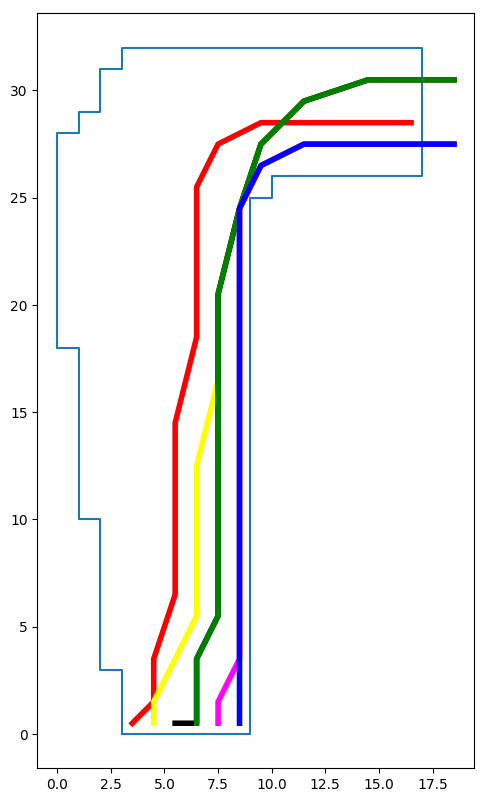

In [109]:
f = plt.figure(num=None, figsize=(8,10), dpi=100, facecolor='w', edgecolor='k')
plt.axes().set_aspect('equal')
cont = np.array(rt_contour_1)
plt.plot(cont[:,0], cont[:,1], figure=f)
cols = ['red','yellow','black','green','magenta','blue']
i = 0
for trace in traces:
    plt.plot(trace[:,0], trace[:,1], figure=f, linewidth=4.0, color=cols[i])
    i += 1

#### Some testing stuff

In [ ]:
getStartState = startPosition(start_line_1[0], start_line_1[2])
test_gen = SeqGen.SequenceGeneratorPlus(
    ImmutableGreedyPolicy(Q),
    getStartState,
    lambda s,a: rt_getTransition(rt_contour_1, s, a, finish_line_1, 
                        getStartPosition=lambda: rt_getStartPosition(start_line_1))
                    + (REWARD,),
    episodes_max = start_line_1[2]-start_line_1[0],
    episode_maxlen = 30
    )

[(state,next_state,is_terminal,action) for state, is_terminal, next_state, action, reward in test_gen]

In [95]:
rt_getTransition(rt_contour_1, (3, 0, 0, 0), 3, finish_line_1, 
                        getStartPosition=lambda: rt_getStartPosition([4,10,8,10]))

(False, (3, 0, 0, 0))

In [ ]:
sequence.get_action.getDistribution()[12, 18, 3, 0]

In [65]:
np.save("Q_100K",Q)
np.save("C_100K",C)

In [102]:
Q = np.load("Q_100K.npy")
C = np.load("C_100K.npy")

In [63]:
returns = np.empty(shape=Q.shape, dtype=object)
for i in np.ndindex(returns.shape): 
    returns[i] = []
